In [ ]:
import scipy.io as scio
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import numpy as np
from skimage.transform import resize
from skimage.exposure import rescale_intensity

label_path = "/content/drive/MyDrive/glaucoma/glaucoma.csv"
img_length = 256
glaucoma_label = pd.read_csv(label_path)
print(glaucoma_label.head())
dataset_annotation = np.zeros((650,img_length,img_length))
dataset_image = np.zeros((650,img_length,img_length,3))
dataset_expCDR = np.zeros(650)
dataset_eye = np.zeros(650, dtype='int8')
dataset_set = np.zeros(650, dtype='int8')
dataset_glaucoma = np.zeros(650, dtype='int8')

directory_annotation = "/content/drive/MyDrive/glaucoma/Semi-automatic-annotations/"
directory_image = "/content/drive/MyDrive/glaucoma/Images/"
for i in range(glaucoma_label.shape[0]):
    n = str(i+1).rjust(3,'0')
    #print(i)
    # annotation
    path=directory_annotation+n+".mat"
    l = scio.loadmat(path)
    img_annotation = l['mask']
    mid = int(img_annotation.shape[1]/2)
    img_annotation = rescale_intensity(img_annotation, in_range=(0, 2), out_range=(0, 255))
    dataset_annotation[i] = resize(img_annotation[:,mid-1024:mid+1024], (img_length,img_length))
    # image
    path=directory_image+n+".jpg"
    img = plt.imread(path)
    dataset_image[i] = resize(img[:,mid-1024:mid+1024,:], (img_length,img_length,3))
    # CDR
    dataset_expCDR[i] = glaucoma_label.loc[i,"ExpCDR"]
    # Eye
    dataset_eye[i] = 0 if glaucoma_label.loc[i,"Eye"] == "OD" else 1
    # Set
    dataset_set[i] = 0 if glaucoma_label.loc[i,"Set"] == "A" else 1
    # Glaucoma
    dataset_glaucoma[i] = glaucoma_label.loc[i,"Glaucoma"]

### augmentation/processing to images here

f = h5py.File("/content/drive/MyDrive/glaucoma/glaucoma.h5","w")
f.create_dataset("image",data = dataset_image)
f.create_dataset("annotation",data = dataset_annotation)
f.create_dataset("expCDR",data = dataset_expCDR)
f.create_dataset("eye",data = dataset_eye)
f.create_dataset("set",data = dataset_set)
f.create_dataset("glaucoma",data = dataset_glaucoma)

f.close()


  Filename  ExpCDR Eye Set  Glaucoma
0  001.jpg  0.7097  OD   A         0
1  002.jpg  0.6953  OS   A         0
2  003.jpg  0.9629  OS   A         0
3  004.jpg  0.7246  OD   A         0
4  005.jpg  0.6138  OS   A         0


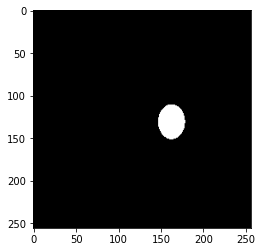

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File("/content/drive/MyDrive/glaucoma/glaucoma.h5",'r+') as f:
    
    img_annotations = f["annotation"]
    plt.hist(img_annotations[0].ravel(), bins=255, color="black")
    plt.imshow(img_annotations[0], cmap = "gray")
    l = img_annotations.shape[0]
    #img_length = 512
    mask = np.zeros((l,img_length,img_length,2), dtype=np.bool)
    for i in range(l):
        mask[i,:,:,0] = img_annotations[i] > 100
        mask[i,:,:,1] = img_annotations[i] > 200
        
    plt.imshow(mask[0,:,:,0], cmap = "gray")
    plt.imshow(mask[0,:,:,1], cmap = "gray")
    
    f.create_dataset("mask",data = mask)

In [ ]:
import numpy as np

def split_train_val(percent_train,seed,train):
    l = np.array(range(img_num))
    np.random.seed(seed)
    np.random.shuffle(l)
    train_num = int(img_num * percent_train)
    if train:
        data_id = np.sort(l[:train_num])
    else:
        data_id = np.sort(l[train_num:])
    return data_id

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
import random
import tensorflow as tf
import os

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

f = h5py.File("/content/drive/MyDrive/glaucoma/glaucoma.h5",'r')
img_num = 650


train_id = split_train_val(0.8, 0, True)
train_data = f["image"][train_id]
train_mask = f["mask"][train_id]

In [ ]:
val_id = split_train_val(0.8, 0, True)
val_data = f["image"][val_id]
val_mask = f["mask"][val_id]

In [ ]:

'''
# check figure
ix = random.randint(0, len(train_id))
plt.imshow(train_data[ix])
plt.show()
plt.imshow(np.squeeze(train_mask[ix,:,:,0]), cmap="gray")
plt.show()
plt.imshow(np.squeeze(train_mask[ix,:,:,1]), cmap="gray")
plt.show()
'''

# Build a U-net model

img_length = 256
img_channel = 3

inputs = tf.keras.layers.Input((img_length, img_length, img_channel))
s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs) #  normalization

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(2, (1, 1), activation='sigmoid') (c9)
model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 256, 256, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_10 (Conv2D)             (None, 256, 256, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                              

In [ ]:
# training
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('/content/drive/MyDrive/glaucoma/model-glaucoma-1.h5', verbose=1, save_best_only=True)
results = model.fit(train_data, train_mask, validation_data=(val_data,val_mask), batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Epoch 1/50
33/33 [==============================] - ETA: 0s - loss: 0.2164 - accuracy: 0.6968
Epoch 00001: val_loss improved from inf to 0.10911, saving model to /content/drive/MyDrive/glaucoma/model-glaucoma-1.h5
33/33 [==============================] - 25s 565ms/step - loss: 0.2164 - accuracy: 0.6968 - val_loss: 0.1091 - val_accuracy: 0.9445
Epoch 2/50
33/33 [==============================] - ETA: 0s - loss: 0.0947 - accuracy: 0.8109
Epoch 00002: val_loss improved from 0.10911 to 0.09233, saving model to /content/drive/MyDrive/glaucoma/model-glaucoma-1.h5
33/33 [==============================] - 15s 471ms/step - loss: 0.0947 - accuracy: 0.8109 - val_loss: 0.0923 - val_accuracy: 0.9968
Epoch 3/50
33/33 [==============================] - ETA: 0s - loss: 0.0814 - accuracy: 0.8064
Epoch 00003: val_loss improved from 0.09233 to 0.07060, saving model to /content/drive/MyDrive/glaucoma/model-glaucoma-1.h5
33/33 [==============================] - 15s 466ms/step - loss: 0.0814 - accuracy: 0.8

In [3]:
from keras.models import load_model
import h5py

with h5py.File("/content/drive/MyDrive/glaucoma/glaucoma.h5",'r') as f:
  '''
  train_id = split_train_val(0.8, 0, True)
  train_data = f["image"][train_id]
  train_mask = f["mask"][train_id]
  val_id = split_train_val(0.8, 0, False)
  val_data = f["image"][val_id]
  val_mask = f["mask"][val_id]
  val_CDR = f["expCDR"][val_id]
  '''
  val_data = f["image"][:]
  val_mask = f["mask"][:]
  val_CDR = f["expCDR"][:]

model = load_model('/content/drive/MyDrive/glaucoma/model-glaucoma-1.h5')
predict = model.predict(val_data)
#print(predict)

In [4]:
print(predict.shape)

(650, 256, 256, 2)


In [25]:
import matplotlib.pyplot as plt

def plot_images(*images):
    images = list(images)
    n = len(images)
    fig, ax = plt.subplots(ncols=n, sharey=True)
    for i, img in enumerate(images):
        ax[i].imshow(img, cmap='gray')
        ax[i].axis('off')
    plt.subplots_adjust(left=0.03, bottom=0.03, right=0.97, top=0.97)
    plt.show()

137


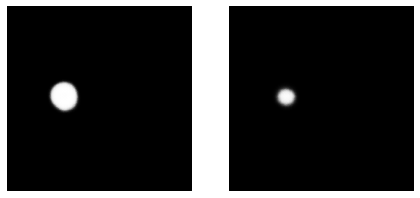

In [53]:
import random
i = random.randint(0,649)
i = 137
print(i)
plot_images(predict[i,:,:,0],predict[i,:,:,1])

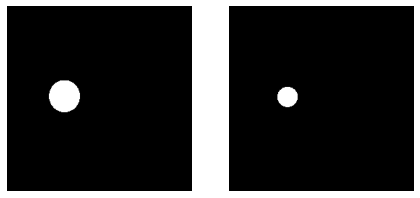

In [36]:
plot_images(val_mask[i,:,:,0],val_mask[i,:,:,1])

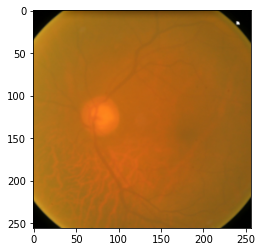

In [54]:
plt.imshow(val_data[i])

In [55]:
predict_img_OD = predict.copy()[i,:,:,0]
predict_img_OC = predict.copy()[i,:,:,1]

[[124. 160.  15.]]


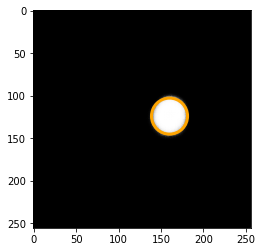

[[124.   160.     8.25]]


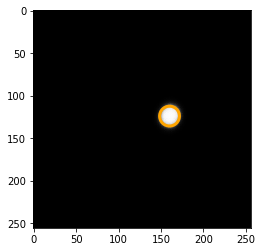

0.5499999999999999
0.5277


In [50]:
from skimage.feature import blob_log
from skimage.io import imread
from math import sqrt

blobs_OD = blob_log(predict_img_OD, min_sigma=10, max_sigma=15, num_sigma=5, threshold=0.3, overlap=.4)
plt.imshow(predict_img_OD, cmap="gray")
for b in blobs_OD:
  y, x, r = b
  r = r * sqrt(2)
  # Create a circle at the blob center
  c = plt.Circle((x, y), r, color='orange', linewidth=3, fill=False)
  # Draw the circle (gca = "get current axis")
  plt.gca().add_artist(c)
print(blobs_OD)
plt.show()

blobs_OC = blob_log(predict_img_OC, min_sigma=3, max_sigma=10, num_sigma=5, threshold=0.3, overlap=.4)
plt.imshow(predict_img_OC, cmap="gray")
for b in blobs_OC:
  a, b, k = b
  k = k * sqrt(2)
  # Create a circle at the blob center
  c = plt.Circle((b, a), k, color='orange', linewidth=3, fill=False)
  # Draw the circle (gca = "get current axis")
  plt.gca().add_artist(c)
print(blobs_OC)
plt.show()

print(k/r)
print(val_CDR[i])

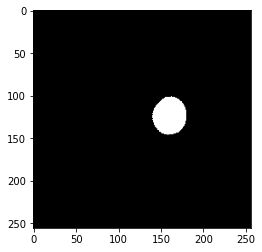

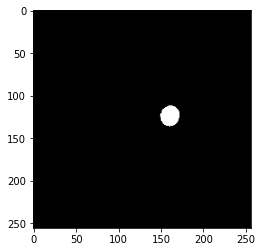

In [51]:
import cv2

ret, predict_img_OD = cv2.threshold(predict_img_OD, 0.5, 1, cv2.THRESH_BINARY)
plt.imshow(predict_img_OD, cmap = "gray")
plt.show()
ret, predict_img_OC = cv2.threshold(predict_img_OC, 0.5, 1, cv2.THRESH_BINARY)
plt.imshow(predict_img_OC, cmap = "gray")
plt.show()

In [52]:
import numpy as np

VDD = np.sum(predict_img_OD,axis = 0)
VCD = np.sum(predict_img_OC,axis = 0)
VDD = max(VDD)
VCD = max(VCD)
print("VDD:",VDD)
print("VCD:",VCD)
print("CDR:",VCD/VDD)
print("Expected CDR:",val_CDR[i])

VDD: 45.0
VCD: 25.0
CDR: 0.5555556
Expected CDR: 0.5277
